In [ ]:
# In this notebook, we will evaluate the results from the fully conv compression ratio experiments


In [5]:

import pathlib
import logging
logging.basicConfig(level=logging.INFO)

from src.eval_utils import *

base_output_dir = pathlib.Path('/Volumes/My Passport for Mac/Multiphase-ae/lassen_output')
files = list(base_output_dir.glob('interfacial_ae_v27_*'))

print(len(files))

24


In [6]:
print(files)

[PosixPath('/Volumes/My Passport for Mac/Multiphase-ae/lassen_output/interfacial_ae_v27_run_00_datadirSIGNED_DISTANCE_EXACT_seed4_dimmults12488_zchannels4'), PosixPath('/Volumes/My Passport for Mac/Multiphase-ae/lassen_output/interfacial_ae_v27_run_01_datadirSIGNED_DISTANCE_EXACT_seed4_dimmults124888_zchannels4'), PosixPath('/Volumes/My Passport for Mac/Multiphase-ae/lassen_output/interfacial_ae_v27_run_02_datadirSIGNED_DISTANCE_EXACT_seed4_dimmults1248888_zchannels4'), PosixPath('/Volumes/My Passport for Mac/Multiphase-ae/lassen_output/interfacial_ae_v27_run_03_datadirHEAVISIDE_seed4_dimmults12488_zchannels4'), PosixPath('/Volumes/My Passport for Mac/Multiphase-ae/lassen_output/interfacial_ae_v27_run_04_datadirHEAVISIDE_seed4_dimmults124888_zchannels4'), PosixPath('/Volumes/My Passport for Mac/Multiphase-ae/lassen_output/interfacial_ae_v27_run_05_datadirHEAVISIDE_seed4_dimmults1248888_zchannels4'), PosixPath('/Volumes/My Passport for Mac/Multiphase-ae/lassen_output/interfacial_ae_v27_

In [7]:
def read_loss_curve_from_file(outdir):
    loss_path = outdir / 'loss_history.json'
    with open(loss_path) as f:
        loss_curve = json.load(f)
    return loss_curve

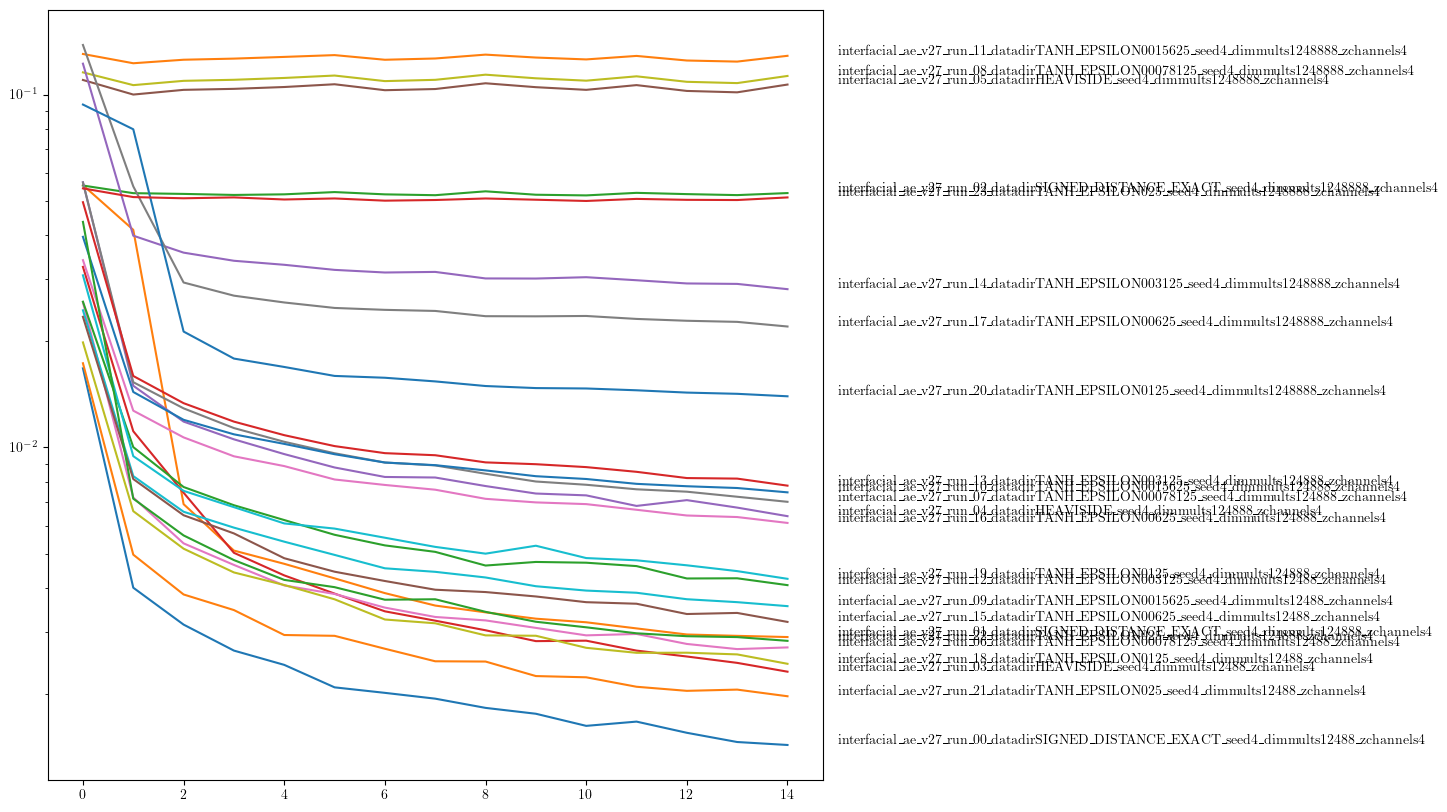

In [8]:
# Compare all the loss curves on one axis


name_to_loss = {}

for f in files:
    try:
        name_to_loss[f] = read_loss_curve_from_file(f)
    except:
        print(f'Could not read {f}')

fig, ax = plt.subplots(figsize=(10, 10))
loss_component = 'Total'
for f, loss in name_to_loss.items():
    ax.plot(loss[loss_component], label=f.name)

    # Annotate name on the end of the curve
    ax.text(len(loss[loss_component]), loss[loss_component][-1], f.name)
#ax.legend()
ax.set_yscale('log')
plt.show()



In [ ]:
# Functions to group the data by interface type and epsilon

def extract_compression_ratio(outdir):
    run_info_path = outdir / 'run_info.json'
    
    with open(run_info_path) as f:
        run_info = json.load(f)
        
    return run_info['compression_ratio']


def extract_interface_type(outdir):
    
    final_part = '_'.join(outdir.stem.split('_')[5:-3])
    final_part = final_part.replace('datadir', '')

    str_to_type = {
        'TANH_EPSILON00078125': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON0015625': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON003125': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON00625': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON0125': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON025': InterfaceType.TANH_EPSILON,
        'HEAVISIDE': InterfaceType.HEAVISIDE,
        'SIGNED_DISTANCE_EXACT': InterfaceType.SIGNED_DISTANCE_EXACT,
        'SIGNED_DISTANCE_APPROXIMATE': InterfaceType.SIGNED_DISTANCE_APPROXIMATE,
    }

    return str_to_type[final_part]

def extract_epsilon(outdir):
    final_part = '_'.join(outdir.stem.split('_')[5:-3])
    
    # Remove 'datadir' from start of string
    final_part = final_part.replace('datadir', '')
    
    str_to_epsilon = {
        'TANH_EPSILON00078125': 0.0078125,
        'TANH_EPSILON0015625': 0.015625,
        'TANH_EPSILON003125': 0.03125,
        'TANH_EPSILON00625': 0.0625,
        'TANH_EPSILON0125': 0.125,
        'TANH_EPSILON025': 0.25,
        'HEAVISIDE': None,
        'SIGNED_DISTANCE_EXACT': None,
        'SIGNED_DISTANCE_APPROXIMATE': None,
    }
    
    return str_to_epsilon[final_part]
    

def get_model_path(outdir):
    return outdir / 'model-15.pt'


def get_dim_mults(outdir):
    model_args_path = outdir / 'construct_model_args.json'
    
    with open(model_args_path) as f:
        model_args = json.load(f)
        
    return model_args['dim_mults']


def get_dataset_path(interfacetype, epsilon):
    if interfacetype == InterfaceType.TANH_EPSILON:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON{epsilon}')
    elif interfacetype == InterfaceType.HEAVISIDE:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/HEAVISIDE')
    elif interfacetype == InterfaceType.SIGNED_DISTANCE_EXACT:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT')
    elif interfacetype == InterfaceType.SIGNED_DISTANCE_APPROXIMATE:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_APPROXIMATE')
    else:
        raise ValueError('Unknown interface type')
    
    
    

In [ ]:
outdir_to_params = {}

for outdir in files:
    print(outdir.stem.split('_'))
    interfacetype = extract_interface_type(outdir)
    compression_ratio = extract_compression_ratio(outdir)
    epsilon = extract_epsilon(outdir)
    model_path = get_model_path(outdir)
    dim_mults = get_dim_mults(outdir)
    dataset_path = get_dataset_path(interfacetype, epsilon)
   
    assert model_path.exists()
    assert dataset_path.exists(), f'{dataset_path} does not exist'
   
    params = {
       'compression_ratio': compression_ratio,
       'interface_type': interfacetype,
       'epsilon': epsilon,
       'model_path': model_path,
       'dataset_path': dataset_path,
        'dim_mults': dim_mults
    }
   
    outdir_to_params[outdir] = params
    
print(outdir_to_params)

In [ ]:
# Run inference for all

for outdir, params in outdir_to_params.items():
    print(outdir)
    outfile = outdir / 'inference.npz'
    
    dataset = load_dataset(params['dataset_path'], max_num_samples=25_000)
    model = load_model(params['model_path'], dim_mults=params['dim_mults'])
    gts, preds = run_inference(dataset, model, N=50)
    
    # Save outdir, preds, params, gt to disk, ready to be reloaded at evaluation time!
    
    np.savez_compressed(outfile, gts=gts, preds=preds, **params)

In [ ]:
# Go over each file, and load predictions, compute metrics from each volume

outdir_to_metrics = {}

for outdir, params in outdir_to_params.items():
    print(outdir)
    outfile = outdir / 'inference.npz'
    data = np.load(outfile)
    
    gts = data['gts']
    preds = data['preds']
    
    # Convert to sharp interface
    interfacetype = params['interface_type']
    
    # Compute metrics
    # 2. Dice coefficient
    
    dices = []
    
    for gt, pred in zip(gts, preds):
        gt = get_phi_sharp(gt, interfacetype)
        pred = get_phi_sharp(pred, interfacetype)
        
        dice = dice_coefficient(gt, pred)
        dices.append(dice)
        
    print(np.mean(dices))
        
    outdir_to_metrics[outdir] = {
        'Dice': dices,
    }
    

In [ ]:
import matplotlib.pyplot as plt
from fractions import Fraction

def float_to_fraction(float_num):
    fraction = Fraction(float_num).limit_denominator()
    return f"{fraction.numerator}/{fraction.denominator}"

# Group data by compression ratio
compression_to_dice_data = {params['compression_ratio']: {} for params in outdir_to_params.values()}

# Sort compression ratios
compression_to_dice_data = dict(sorted(compression_to_dice_data.items(), key=lambda item: item[0]))

for outdir, params in outdir_to_params.items():
    compression_ratio = params['compression_ratio']
    interface_type = params['interface_type']
    epsilon = params['epsilon']
    dice_scores = outdir_to_metrics[outdir]['Dice']

    if interface_type == InterfaceType.TANH_EPSILON:
        label = f'TANH_{epsilon}'
    elif interface_type == InterfaceType.SIGNED_DISTANCE_EXACT:
        label = 'SDF'
    elif interface_type == InterfaceType.SIGNED_DISTANCE_APPROXIMATE:
        label = 'SDF approx'
    else:
        label = 'Sharp'

    if label not in compression_to_dice_data[compression_ratio]:
        compression_to_dice_data[compression_ratio][label] = []

    compression_to_dice_data[compression_ratio][label].extend(dice_scores)

# Sort labels by interface type
for compression_ratio in compression_to_dice_data:
    compression_to_dice_data[compression_ratio] = dict(sorted(compression_to_dice_data[compression_ratio].items(), key=lambda item: item[0]))

# Sort labels by epsilon value
for compression_ratio in compression_to_dice_data:
    compression_to_dice_data[compression_ratio] = dict(sorted(compression_to_dice_data[compression_ratio].items(), key=lambda item: float(item[0].split('_')[-1]) if 'TANH' in item[0] else 0))
    
# Convert epsilon values to fractions
for compression_ratio in compression_to_dice_data:
    for label in list(compression_to_dice_data[compression_ratio].keys()):
        if 'TANH' in label:
            epsilon = float(label.split('_')[-1])
            x = compression_to_dice_data[compression_ratio].pop(label)
            compression_to_dice_data[compression_ratio][f'Tanh {float_to_fraction(epsilon)}'] = x

# Create box plots
fig, axs = plt.subplots(1, len(compression_to_dice_data), figsize=(12, 3), dpi=200)

for i, compression_ratio in enumerate(compression_to_dice_data):
    data = [compression_to_dice_data[compression_ratio][label] for label in compression_to_dice_data[compression_ratio]]
    labels = list(compression_to_dice_data[compression_ratio].keys())
    
    axs[i].boxplot(data, tick_labels=labels)
    axs[i].set_title(f'Compression ratio={int(compression_ratio)}')
    axs[i].set_xlabel('Interface Type')
    axs[i].set_ylabel('Dice Coefficient')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].tick_params(axis='x', rotation=90)
    
axs[0].set_ylim(0.9, 1)
axs[1].set_ylim(0.9, 1)

plt.tight_layout()
plt.show()

In [ ]:
# Compute all HD metrics and then plot them as above

def hausdorff_distance(gt_patch, pred_patch, level: float = 0.5):
    """Returns the Hausdorff distance of the foreground region, obtained by thresholding the images at level

    Note:
        The distance is in units of voxels, assumes isotropic voxels

    Args:
        gt_patch: Ground truth patch
        pred_patch: Predicted patch
        level: Threshold level
        max_num_points: Maximum number of points to use in the distance calculation (for speed purposes)
    """
    gt_patch = gt_patch > level
    pred_patch = pred_patch > level

    gt_indices = np.argwhere(gt_patch)
    pred_indices = np.argwhere(pred_patch)
    
    if len(gt_indices) == 0 or len(pred_indices) == 0:
        return np.nan

    h_1 = directed_hausdorff(gt_indices, pred_indices)[0]
    h_2 = directed_hausdorff(pred_indices, gt_indices)[0]
    return max(h_1, h_2)


outdir_to_hausdorff = {}

for outdir, params in outdir_to_params.items():
    print(outdir)
    outfile = outdir / 'inference.npz'
    data = np.load(outfile)

    gts = data['gts']
    preds = data['preds']

    # Convert to sharp interface
    interfacetype = params['interface_type']

    hds = []

    for gt, pred in tqdm(list(zip(gts, preds))[:50]):
        gt = get_phi_sharp(gt, interfacetype)
        pred = get_phi_sharp(pred, interfacetype)
        
        hd = hausdorff_distance(gt, pred, level=0.5)
        hds.append(hd)

    print(np.mean(hds))

    outdir_to_metrics[outdir] = {
        'Hausdorff': hds,
    }



In [ ]:


# Filter out any nan values
for outdir, metrics in outdir_to_metrics.items():
    hds = metrics['Hausdorff']
    hds = [hd for hd in hds if not np.isnan(hd)]
    outdir_to_metrics[outdir]['Hausdorff'] = hds

def float_to_fraction(float_num):
    fraction = Fraction(float_num).limit_denominator()
    return f"{fraction.numerator}/{fraction.denominator}"

# Group data by compression ratio
compression_to_hd_data = {params['compression_ratio']: {} for params in outdir_to_params.values()}

# Sort compression ratios
compression_to_hd_data = dict(sorted(compression_to_hd_data.items(), key=lambda item: item[0]))

for outdir, params in outdir_to_params.items():
    compression_ratio = params['compression_ratio']
    interface_type = params['interface_type']
    epsilon = params['epsilon']
    hd_scores = outdir_to_metrics[outdir]['Hausdorff']

    if interface_type == InterfaceType.TANH_EPSILON:
        label = f'TANH_{epsilon}'
    elif interface_type == InterfaceType.SIGNED_DISTANCE_EXACT:
        label = 'SDF'
    elif interface_type == InterfaceType.SIGNED_DISTANCE_APPROXIMATE:
        label = 'SDF approx'
    else:
        label = 'Sharp'

    if label not in compression_to_hd_data[compression_ratio]:
        compression_to_hd_data[compression_ratio][label] = []

    compression_to_hd_data[compression_ratio][label].extend(hd_scores)

# Sort labels by interface type
for compression_ratio in compression_to_hd_data:
    compression_to_hd_data[compression_ratio] = dict(sorted(compression_to_hd_data[compression_ratio].items(), key=lambda item: item[0]))

# Sort labels by epsilon value
for compression_ratio in compression_to_hd_data:
    compression_to_hd_data[compression_ratio] = dict(sorted(compression_to_hd_data[compression_ratio].items(), key=lambda item: float(item[0].split('_')[-1]) if 'TANH' in item[0] else 0))

# Convert epsilon values to fractions
for compression_ratio in compression_to_hd_data:
    for label in list(compression_to_hd_data[compression_ratio].keys()):
        if 'TANH' in label:
            epsilon = float(label.split('_')[-1])
            x = compression_to_hd_data[compression_ratio].pop(label)
            compression_to_hd_data[compression_ratio][f'Tanh {float_to_fraction(epsilon)}'] = x

# Create box plots
fig, axs = plt.subplots(1, len(compression_to_hd_data), figsize=(12, 3), dpi=200)

for i, compression_ratio in enumerate(compression_to_hd_data):
    data = [compression_to_hd_data[compression_ratio][label] for label in compression_to_hd_data[compression_ratio]]
    labels = list(compression_to_hd_data[compression_ratio].keys())

    axs[i].boxplot(data, tick_labels=labels)
    axs[i].set_title(f'Compression Ratio={int(compression_ratio)}')
    axs[i].set_xlabel('Interface Type')
    axs[i].set_ylabel('Hausdorff distance')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].tick_params(axis='x', rotation=90)
    
axs[0].set_ylim(0, 5)
axs[1].set_ylim(0, 10)
axs[2].set_ylim(0, 40)

plt.tight_layout()
plt.show()

In [ ]:

from scipy.ndimage import label

# Function to compute droplet PDF
def compute_droplet_pdf(arr):
    labeled_arr, num_labels = label(arr)
    sizes = np.bincount(labeled_arr.ravel())
    return sizes[1:]

# Group PDF data by interface type, epsilon, and mu value

interface_to_epsilon_to_mu_data = {}

for interface in InterfaceType:
    try:
        epsilons = sorted(set(params['epsilon'] for params in outdir_to_params.values() if params['interface_type'] == interface))
    except:
        epsilons = [None]
    interface_to_epsilon_to_mu_data[interface] = {epsilon: {mu: {'gt': [], 'pred': []} for mu in mus} for epsilon in epsilons}

print(interface_to_epsilon_to_mu_data)

for outdir, params in outdir_to_params.items():
    mu = params['mu']
    epsilon = params['epsilon']
    interface_type = params['interface_type']
    gts = outdir_to_metrics[outdir]['gts']
    preds = outdir_to_metrics[outdir]['preds']
    
    for gt, pred in zip(gts, preds):
        gt, pred = get_phi_sharp_pred_and_gt(pred, gt, interface_type)
        interface_to_epsilon_to_mu_data[interface_type][epsilon][mu]['gt'].extend(compute_droplet_pdf(gt))
        interface_to_epsilon_to_mu_data[interface_type][epsilon][mu]['pred'].extend(compute_droplet_pdf(pred))


In [ ]:
def get_label(interfacetype, epsilon) -> str:
    if interfacetype == InterfaceType.TANH_EPSILON:
        return f'TANH_{epsilon}'
    elif interfacetype == InterfaceType.SIGNED_DISTANCE_EXACT:
        return 'SDF exact'
    elif interfacetype == InterfaceType.SIGNED_DISTANCE_APPROXIMATE:
        return 'SDF approx'
    elif interfacetype == InterfaceType.HEAVISIDE:
        return 'Sharp'
    else:
        raise ValueError('Unknown interface type')
    
# Now change interface_to_epsilon_to_mu_data to label_to_mu_data

label_to_mu_data = {}

for interface, epsilon_to_mu_data in interface_to_epsilon_to_mu_data.items():
    for epsilon, mu_data in epsilon_to_mu_data.items():
        label = get_label(interface, epsilon)
        print(label)
        
        if label not in label_to_mu_data:
            label_to_mu_data[label] = {mu: {'gt': [], 'pred': []} for mu in mus}
        
        for mu in mus:
            label_to_mu_data[label][mu]['gt'].extend(mu_data[mu]['gt'])
            label_to_mu_data[label][mu]['pred'].extend(mu_data[mu]['pred'])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the droplet PDFs for each label
fig, axs = plt.subplots(len(label_to_mu_data), 1, figsize=(4, 12), dpi=200, sharex=True, sharey=True)

colors = ['b', 'g', 'r']
num_bins = 25

for i, (label, mu_data) in enumerate(label_to_mu_data.items()):
    for j, mu in enumerate(mus):
        data = mu_data[mu]
        print(label, mu, len(data['gt']), len(data['pred']))
        min_bin = 1
        max_bin = 1e6
        bins = np.logspace(np.log10(min_bin), np.log10(max_bin), num_bins)

        axs[i].hist(data['gt'], bins=bins, alpha=0.5, label=f'GT mu={mu}', histtype='step', color=colors[j])
        axs[i].hist(data['pred'], bins=bins, alpha=0.5, label=f'Pred mu={mu}', histtype='step', linestyle='dashed', color=colors[j])
        axs[i].set_title(f'{label}')
        axs[i].set_xlabel('Droplet size')
        axs[i].set_ylabel('Frequency')
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].set_yscale('log')
        axs[i].set_xscale('log')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

def compute_surface_area_density(phi):
    # Assume phi represents a volume fraction
    dx = 1 / phi.shape[-1]
    grad_phi = np.gradient(phi, dx)  # List of (64, 64, 64) arrays
    abs_grad_phi = np.sqrt(np.sum([g**2 for g in grad_phi], axis=0))
    surface_area = np.sum(abs_grad_phi)
    volume = np.sum(phi)
    return surface_area / volume

def compute_num_components(phi):
    labeled_arr, num_labels = ndimage.label(phi)
    return num_labels

def compute_volume_fraction(phi):
    return np.sum(phi) / phi.size

plot_label_to_mu_to_sigmas = {label: {mu: [] for mu in mus} for label in label_to_mu_data}
plot_label_to_mu_to_dices = {label: {mu: [] for mu in mus} for label in label_to_mu_data}
plot_label_to_mu_to_num_components = {label: {mu: [] for mu in mus} for label in label_to_mu_data}
plot_label_to_mu_to_volume_fraction = {label: {mu: [] for mu in mus} for label in label_to_mu_data}

for outdir, params in outdir_to_params.items():
    gts = outdir_to_metrics[outdir]['gts']
    interfacetype = params['interface_type']
    plot_label = get_label(interfacetype, params['epsilon'])
    mu = params['mu']
    dice_scores = outdir_to_metrics[outdir]['Dice']
    
    assert len(gts) == len(dice_scores)

    for gt in gts:
        phi = get_phi_sharp(gt, interfacetype)
        sigma = compute_surface_area_density(phi)
        vol_frac = compute_volume_fraction(phi)
        num_components = compute_num_components(phi)
        plot_label_to_mu_to_sigmas[plot_label][mu].append(sigma)
        plot_label_to_mu_to_num_components[plot_label][mu].append(num_components)
        plot_label_to_mu_to_volume_fraction[plot_label][mu].append(vol_frac)
        
    for dice in dice_scores:
        plot_label_to_mu_to_dices[plot_label][mu].append(dice)
        

In [ ]:
import matplotlib.cm as cm

# Scatter plot of sigma vs dice coefficient
fig, axs = plt.subplots(3, 3, figsize=(7, 6), sharey=True, dpi=200)
axs = axs.flatten()  # Flatten the 3x3 array to make indexing easier

unique_mu_values = sorted({mu for mu_to_sigmas in plot_label_to_mu_to_sigmas.values() for mu in mu_to_sigmas})
colormap = cm.get_cmap('viridis', len(unique_mu_values) + 1)
mu_to_color = {mu: colormap(i) for i, mu in enumerate(unique_mu_values)}

for i, label in enumerate(plot_label_to_mu_to_sigmas):
    mu_to_sigmas = plot_label_to_mu_to_sigmas[label]
    mu_to_dices = plot_label_to_mu_to_dices[label]

    for mu, sigma in mu_to_sigmas.items():
        dice_scores = mu_to_dices[mu]
        axs[i].scatter(sigma, dice_scores, alpha=0.25, label=f'$\\mu$={mu}', c=mu_to_color[mu])

    axs[i].set_title(label)
    axs[i].set_xlabel('$\\Sigma$')
    axs[i].set_ylabel('Dice coefficient')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].set_xlim(0, 75)
    axs[i].set_ylim(0.0, 1)

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Add a custom legend outside the plot
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles[:3], labels[:3], loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [ ]:
# Scatter plot of num_components vs dice coefficient

fig, axs = plt.subplots(3, 3, figsize=(7, 6), sharey=True, dpi=200)
axs = axs.flatten()  # Flatten the 3x3 array to make indexing easier

for i, label in enumerate(plot_label_to_mu_to_num_components):
    mu_to_num_components = plot_label_to_mu_to_num_components[label]
    mu_to_dices = plot_label_to_mu_to_dices[label]

    for mu, num_components in mu_to_num_components.items():
        dice_scores = mu_to_dices[mu]
        axs[i].scatter(num_components, dice_scores, alpha=0.25, label=f'$\\mu$={mu}', c=mu_to_color[mu])

    axs[i].set_title(label)
    axs[i].set_xlabel('Num components')
    axs[i].set_ylabel('Dice coefficient')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    
# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])
    
# Add a custom legend outside the plot
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles[:3], labels[:3], loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [ ]:
# Scatter plot of volume fraction vs dice coefficient

fig, axs = plt.subplots(3, 3, figsize=(7, 6), sharey=True, dpi=200)
axs = axs.flatten()  # Flatten the 3x3 array to make indexing easier

for i, label in enumerate(plot_label_to_mu_to_volume_fraction):
    mu_to_volfrac = plot_label_to_mu_to_volume_fraction[label]
    mu_to_dices = plot_label_to_mu_to_dices[label]

    for mu, num_components in mu_to_volfrac.items():
        dice_scores = mu_to_dices[mu]
        axs[i].scatter(num_components, dice_scores, alpha=0.25, label=f'$\\mu$={mu}', color=mu_to_color[mu])

    axs[i].set_title(label)
    axs[i].set_xlabel('Volume fraction')
    axs[i].set_ylabel('Dice coefficient')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Add a custom legend outside the plot
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles[:3], labels[:3], loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import skimage

def visualize_gt_pred(interface_type, mu, epsilon, sample_index):
    for outdir, params in outdir_to_params.items():
        if params['interface_type'] == interface_type and params['mu'] == mu and params['epsilon'] == epsilon:
            
            data = np.load(outdir / 'inference.npz')
            gts = data['gts']
            preds = data['preds']
            
            gt = gts[sample_index]
            pred = preds[sample_index]
            
            gt = get_phi_sharp(gt, interface_type)
            pred = get_phi_sharp(pred, interface_type)
            
            dice = dice_coefficient(gt, pred)
            vol_frac = compute_volume_fraction(gt)
            sigma = compute_surface_area_density(gt)
            num_components = compute_num_components(gt)
            
            print(f'Dice: {dice}, Vol frac: {vol_frac}, Sigma: {sigma}, Num components: {num_components}')
            
            fig, axs = plt.subplots(1, 2, figsize=(12, 6))
            axs[0].imshow(gt[gt.shape[0] // 2], cmap='gray')
            axs[0].set_title('Ground Truth')
            axs[1].imshow(pred[pred.shape[0] // 2], cmap='gray')
            axs[1].set_title('Prediction')
            plt.show()



            fig = plt.figure(figsize=(6, 6), dpi=200)
            ax = fig.add_subplot(121, projection="3d")
            verts, faces, normals, values = skimage.measure.marching_cubes(
                gt, 0.5, spacing=(1, 1, 1), allow_degenerate=False, method='lewiner'
            )
            mesh = Poly3DCollection(verts[faces])
            mesh.set_edgecolor("k")
            mesh.set_linewidth(0.05)
            mesh.set_alpha(0.9)
            ax.add_collection3d(mesh)
            
            ax = fig.add_subplot(122, projection="3d")
            verts, faces, normals, values = skimage.measure.marching_cubes(
                pred, 0.5, spacing=(1, 1, 1), allow_degenerate=False, method='lewiner'
            )
            mesh = Poly3DCollection(verts[faces])
            mesh.set_edgecolor("k")
            mesh.set_linewidth(0.05)
            mesh.set_alpha(0.9)
            ax.add_collection3d(mesh)

            plt.tight_layout()
            break

# Example usage
visualize_gt_pred(InterfaceType.TANH_EPSILON, 2.0, 1/32, 0)

In [ ]:
def find_samples_in_volume_fraction_window(interface_type, mu, epsilon, volume_fraction_min, volume_fraction_max):
    sample_indices = []
    
    for outdir, params in outdir_to_params.items():
        if params['interface_type'] == interface_type and params['mu'] == mu and params['epsilon'] == epsilon:
            data = np.load(outdir / 'inference.npz')
            gts = data['gts']
            preds = data['preds']
            
            for i, gt, pred in zip(range(len(gts)), gts, preds):
                gt = get_phi_sharp(gt, interface_type)
                pred = get_phi_sharp(pred, interface_type)
                dice = dice_coefficient(gt, pred)
                vol_frac = compute_volume_fraction(gt)
                if volume_fraction_min <= vol_frac <= volume_fraction_max:
                    sample_indices.append((i, dice))
            
    return sample_indices

# Example usage
sample_indices = find_samples_in_volume_fraction_window(InterfaceType.TANH_EPSILON, 1.0, 1/32, 0.25, 0.26)
print(sample_indices)

In [ ]:
# Visualise a good and bad sample with same volume fraction

visualize_gt_pred(InterfaceType.TANH_EPSILON, 1.0, 1/32, 11)
visualize_gt_pred(InterfaceType.TANH_EPSILON, 1.0, 1/32, 42)

# Summary

 - 

# Next steps

  - 